# Задача: исследование причин оттока клиентов банка "МПБ"

# Оглавление

1. [Загрузка и изучение данных](#data_load)
    * [Изучение структуры таблицы и полей таблицы](#data_check)
    * [Поиск пропусков, дубликатов и определение метода их обработки](#refilling)
    * [Проверка на ошибки стиля и регистра](#style_check)  
2. [Предобработка данных](#data_change)
    * [Кодирование данных](#data_code)
    * [Обработка дубликатов](#dupe_fix)
    * [Обработка ошибок стиля и регистра](#style_fix)
    * [Классификация и обработка пропусков](#zero_fix)
    * [Конвертация одних типов данных в другие при необходимости](#data_conv)
3. [Анализ данных](#data_analysis)
    * [Поиск корреляции признака churn с другими признаками](#churn_correl)
    * [Анализ признаков относительно признака оттока](#churn_analysis)
    * [Анализ портрета клиента в разрезе имеющихся признаков](#user_cut)       
4. [Выдвижение гипотез](#hypos)
    * [Формирование списка гипотез](#hypo_list)
    * [Проверка гипотез](#hypo_test)    
5. [Промежуточные выводы](#pref_total)
    * [Выводы по анализу клиентских групп и их корреляции](#corr_total)
    * [Выводы по проверенным гипотезам](#hypo_total)   
6. [Сегментация](#slicing)
    * [Сегментация клиентской базы по заданным параметрам](#client_slicing)
    * [Выявление сегментов, в которых доля оттока наиболее высока, приоритезация сегментов](#slice_prior)
7. [Общие выводы о потенциальной возможности удержания клиентов](#itogo)
    * [Описание получившихся клиентских групп, чьи члены чаще всего выбирают выход из обслуживания](#slacker_group)
    * [Предложения по возвращению и удержанию групп оттока](#bind_group)

## Загрузка и изучение данных<a id="data_load"></a>

### Изучение структуры таблицы и полей таблицы<a id="data_check"></a>

In [1]:
!pip install phik --quiet

In [2]:
# импортируем рабочие модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import matplotlib.ticker as mtick
import phik
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
# импортируем данные
df = pd.read_csv('***')

In [4]:
df.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Таблица - массив данных о клиентах банка, в таблице 12 столбцов, 10000 строк, форматы данных - obj, int, float. Согласно описанию содержимое составляет:
- USERID — идентификатор пользователя;
- score — баллы кредитного скоринга;
- city — город;
- gender — пол;
- age — возраст;
- equity — количество баллов собственности;
- balance — баланс на счёте;
- products — количество продуктов, которыми пользуется клиент;
- credit_card — есть ли кредитная карта;
- last_activity — активный клиент;
- EST_SALARY — оценочный доход клиента;
- сhurn — признак оттока.

### Поиск пропусков, дубликатов и определение метода их обработки<a id="refilling"></a>

In [6]:
# просмотр информации о таблицах, проверка на наличие дубликатов и пустот
for i in [df]:
    display(i.head(3))
    print(i.duplicated().sum(), i.isnull().sum())

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0


0 USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64


Имеется 26 аномалий в столбце age и 2295 аномалий в столбце balance. Необходимо рассмотреть их подробнее и принять решение об обработке, если необходимо.

### Проверка на ошибки стиля и регистра<a id="style_check"></a>

Столбцы USERID и EST_SALARY выбиваются из общего стиля, и будут стандартизированы позднее.

## Предобработка данных<a id="data_change"></a>

### Обработка дубликатов<a id="dupe_fix"></a>

Столбец userid содержит уникальные значения в виде идентификаторов клиентов, и надо разобраться, как они повторяются, при полном повторении эти строки следует убрать, чтоб в расчёты не вкралась ошибка.

In [7]:
# выборка дублей из датафрейма в отдельный список
mask = df.loc[df['USERID'].duplicated()]

In [8]:
# проверка выборки на длину по значениям
mask['USERID'].nunique()

73

In [9]:
mask['EST_SALARY'].nunique()

73

Так как длина списка EST_SALARY совпадает по длине с USERID, а шанс совпадения значения est_salary до копеек исчезающе мал, приходим к выводу, что что во фрейме нет одинаковых значений по этому параметру, и дубликаты из основного фрейма не нужно удалять. Вероятно, USERID был сдублирован при ручном вводе.

In [10]:
# удаление дубликатов из фрейма по значениям в userid
df.drop_duplicates(subset='USERID', inplace = True)

In [11]:
#оставим отдельно фрейм без перекодировки
df_true=df

In [12]:
# так как некоторые столбцы не будут применятьcя в матрице, удаляем их из фрейма
df = df.drop('USERID', axis=1)

### Обработка ошибок стиля и регистра<a id="style_fix"></a>

In [13]:
# перевод названий столбцов в нижний регистр
df = df.rename(str.lower, axis='columns')
df_true=df_true.rename(str.lower, axis='columns')

### Кодирование данных<a id="data_code"></a>

Имеется два столбца, где данные стоит перекодировать - это city и gender, для удобства учёта.

In [14]:
#city
df=pd.get_dummies(df, columns=["city"])

In [15]:
#gender
df=pd.get_dummies(df, columns=["gender"])

In [16]:
# перевод названий столбцов в нижний регистр уже после перекодирования
df = df.rename(str.lower, axis='columns')

In [17]:
# переименуем столбцы в едином стиле
df = df.rename(columns={"city_ростов": "ros_city", "city_рыбинск": "ryb_city", "city_ярославль": "yar_city", \
                       "gender_ж": "gender_f", "gender_м": "gender_m"})

### Классификация и обработка пропусков<a id="zero_fix"></a>

Как было рассмотрено выше, обработка пропусков нецелосообразна, т.к. ведёт к искажению общей картины, особенно в разрезе расчёта средней зарплаты. 
Пропуски в столбце age - 26 шт, скорей всего вызваны ошибкой при заполнении, и относятся к категории MCAR.
Пропуски в столбце balance - 2259 шт, относятся к категории MNAR, и нельзя прямо сказать, чем вызвано отсутствие информации - нежеланием клиента заполнять данную графу, отсутсвием информации у самого банка (например, клиент является ИП и не получает зарплату) либо является временно неработающим. На текущий момент заполнять пропуски нельзя.

In [18]:
# посмотрим отдельно пропуски в столбце
display(df[df['balance'].isna()].describe())

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,ros_city,ryb_city,yar_city,gender_f,gender_m
count,2260.000000,2260.000000,2260.000000,0.0,2260.000000,2260.000000,2260.000000,2.260000e+03,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000
mean,865.334956,42.125664,0.051770,NaN,1.161504,0.815487,0.549115,2.267006e+05,0.005752,0.103982,0.254867,0.641150,0.441150,0.558850
std,89.669447,11.953138,0.227525,NaN,0.401442,0.387988,0.497692,1.999817e+05,0.075642,0.305305,0.435883,0.479769,0.496635,0.496635
min,642.000000,18.000000,0.000000,NaN,0.000000,0.000000,0.000000,2.027403e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,871.000000,33.000000,0.000000,NaN,1.000000,1.000000,0.000000,1.204570e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,903.000000,40.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.747554e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,922.000000,49.000000,0.000000,NaN,1.000000,1.000000,1.000000,2.404518e+05,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,990.000000,86.000000,3.000000,NaN,3.000000,1.000000,1.000000,1.333687e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
display(df[df['age'].isna()].describe())

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,ros_city,ryb_city,yar_city,gender_f,gender_m
count,4.000000,0.0,4.000000,4.000000e+00,4.0,4.00,4.0,4.000000,4.00,4.00,4.00,4.00000,4.00000,4.00000
mean,857.750000,NaN,3.500000,2.080754e+06,2.0,0.25,1.0,160103.335000,0.25,0.25,0.25,0.50000,0.50000,0.50000
std,49.587465,NaN,1.914854,3.680897e+06,0.0,0.50,0.0,165819.775026,0.50,0.50,0.50,0.57735,0.57735,0.57735
min,829.000000,NaN,1.000000,1.886488e+05,2.0,0.00,1.0,63310.220000,0.00,0.00,0.00,0.00000,0.00000,0.00000
25%,832.750000,NaN,2.500000,2.259101e+05,2.0,0.00,1.0,72232.730000,0.00,0.00,0.00,0.00000,0.00000,0.00000
50%,835.000000,NaN,4.000000,2.663230e+05,2.0,0.00,1.0,84490.980000,0.00,0.00,0.00,0.50000,0.50000,0.50000
75%,860.000000,NaN,5.000000,2.121166e+06,2.0,0.25,1.0,172361.585000,0.25,0.25,0.25,1.00000,1.00000,1.00000
max,932.000000,NaN,5.000000,7.601719e+06,2.0,1.00,1.0,408121.160000,1.00,1.00,1.00,1.00000,1.00000,1.00000


In [20]:
# и для сравнения - во всём фрейме
display(df.describe())

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,ros_city,ryb_city,yar_city,gender_f,gender_m
count,9927.000000,9923.000000,9927.000000,7.667000e+03,9927.000000,9927.000000,9927.000000,9.927000e+03,9927.000000,9927.000000,9927.000000,9927.000000,9927.000000,9927.000000
mean,848.735973,42.729215,2.634633,8.289016e+05,1.871562,0.679863,0.523522,1.478914e+05,0.183338,0.142742,0.267352,0.589906,0.499144,0.500856
std,65.392866,12.177008,1.979286,1.985272e+06,0.792955,0.466552,0.499472,1.393658e+05,0.386963,0.349827,0.442600,0.491875,0.500024,0.500024
min,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,802.000000,33.000000,0.000000,2.952611e+05,1.000000,0.000000,0.000000,7.525178e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,853.000000,40.000000,3.000000,5.248943e+05,2.000000,1.000000,1.000000,1.197114e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,900.000000,51.000000,4.000000,9.808015e+05,2.000000,1.000000,1.000000,1.746733e+05,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Исходя из таблицы можно предположить, что клиенты с незаполненным балансом чуть больший скоринг, низкий балл недвижимости, более высокий уровень заработной платы  и очень низкий отток, в сравнении с общей массой клинтов.

In [21]:
# проверим, соотносится ли отток с незаполненным балансом
df[df['balance'].isna()]['churn'].value_counts()

0    2247
1      13
Name: churn, dtype: int64

Всего 13 пересечений, предположение не подтверждается, пропуски лучше оставить на месте, т.к. нет методы заполнения, которую можно привязать к этим клиентам (вроде совпадения по месту работы и должности).

In [22]:
# создадим копию фрейма матрицы
df_mat_nans=df

In [23]:
# обозначим наличие пропуска в столбце как -999
df_mat_nans['age'].fillna(-999, inplace=True)

In [24]:
# создадим столбец с сортировкой, где пропуски в категории age будут 1, а отсутствие пропуcков - 0
df_mat_nans.loc[df_mat_nans['age'] == -999, 'age_ref'] = '1'
df_mat_nans.loc[df_mat_nans['age'] > 0, 'age_ref'] = '0'

In [25]:
# обозначим наличие пропуска в столбце как -999
df_mat_nans['balance'].fillna(-999, inplace=True)

In [26]:
# создадим столбец с сортировкой, где пропуски в категории balance будут 1, а отсутствие пропуcков - 0
df_mat_nans.loc[df_mat_nans['balance'] == -999, 'balance_ref'] = '1'
df_mat_nans.loc[df_mat_nans['balance'] > -1, 'balance_ref'] = '0'

In [27]:
# перекодируем пропуски в матрице корреляций, и вынесем их в отдельные столбцы
df_mat_nans=pd.get_dummies(df_mat_nans, columns=['age_ref', 'balance_ref'], dtype='int')

In [28]:
# оставим столбцы с нужными значениями
#df_mat_nans=df_mat_nans[['score','equity','products','credit_card', 'last_activity', 'est_salary', 'churn', 'ros_city', \
                   #'ryb_city', 'yar_city', 'gender_f', 'gender_m', 'age_nan', 'balance_nan']]

In [29]:
df_mat_nans[['age_ref_1', 'balance_ref_1']].head(3)

,age_ref_1,balance_ref_1
0,0,0
1,0,0
2,0,1


Теперь во фрейме есть два отдельных столбца, где закодированы значения пропусков из age и balance, и по ним дальше будет строиться матрица корреляции.

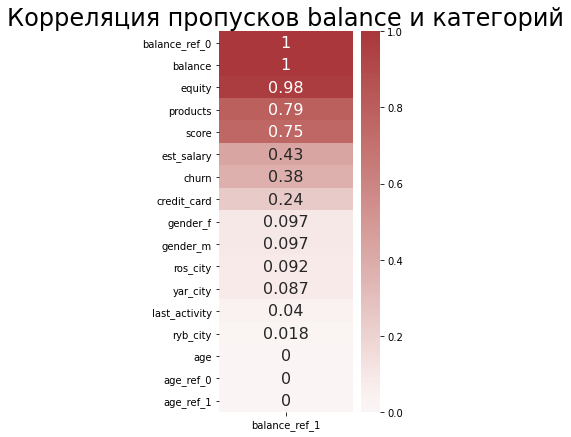

In [30]:
# построим матрицу по пропускам в столбце balance
plt.figure(figsize = (3,7))
bal_voids = df_mat_nans.phik_matrix(interval_cols=['score', 'age', 'est_salary'])[['balance_ref_1']] \
    .drop(index='balance_ref_1', axis=0).sort_values(by='balance_ref_1', ascending=False)
sns.heatmap(bal_voids, annot=True, fmt='.2g',  vmax=1, vmin=0, cmap='vlag', center = 0, annot_kws={"fontsize":16})
sns.set(font_scale=2)
plt.title('Корреляция пропусков balance и категорий')
plt.show()

Корреляция пропусков в столбце balance связана с категорями equity и по шкале отмечается как "Очень высокая", products и score - отмечаются как "Высокая". Исходя из обыденной логики, нулевой баланс на счету может свидетельствовать или о намерении закрыть счёт и уйти из банка (и тогда ни прочие продукты, ни рейтинг в банке его не интересуют), или просто быть недостаточно обеспеченным человеком (и тогда продукты сверх минимума ему не нужны), из-за чего менеджер и поставит ему низкие баллы в этих категориях. Таким образом, пропуски в столбце balance можно отнести к категории MNAR (Missing Not At Random / Отсутствует не случайно).

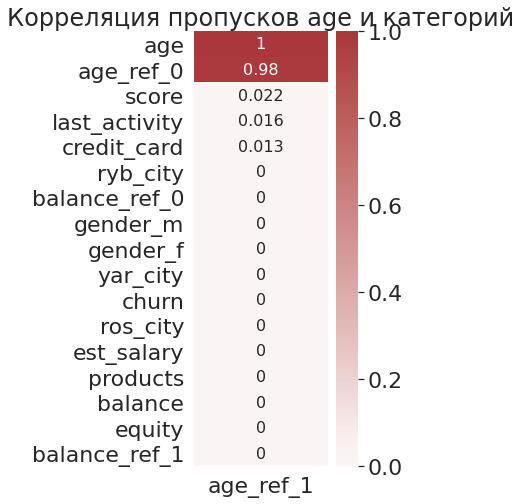

In [31]:
# построим матрицу по пропускам в столбце age
plt.figure(figsize = (3,8))
age_voids = df_mat_nans.phik_matrix(interval_cols=['score', 'balance', 'est_salary'])[['age_ref_1']] \
    .drop(index='age_ref_1', axis=0).sort_values(by='age_ref_1', ascending=False)
sns.heatmap(age_voids, annot=True, fmt='.2g',  vmax=1, vmin=0, cmap='vlag', center = 0, annot_kws={"fontsize":16})
sns.set(font_scale=2)
plt.title('Корреляция пропусков age и категорий')
plt.show()

Корреляция пропусков в столбце age связана с категорями score, last_activity и credit_card - отмечается как "Слабая". Но, так как количество их составляет в процентном отношении порядка 0,001% от общего числа элементов, построить по ним никакой достоверной последовательности нельзя. Таким образом, пропуски в столбце age можно отнести к категории MCAR (Missing Completely At Random / Отсутствует совершенно случайно).

Как было найдено выше, в столбце products есть значения "0", что маловероятно, т.к. клиент не может быть клиентом, не обладая ни одним действующим продуктом(услугой).

In [32]:
df[df['products'] == 0]

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,ros_city,ryb_city,yar_city,gender_f,gender_m,age_ref,balance_ref
8957,962.0,79.0,3,-999.0,0,0,0,25063.96,1,0,1,0,1,0,0,1


In [33]:
# единственная строка, можно безболезненно удалить
df = df[df['products']!=0]
df_true = df_true[df_true['products']!=0]

### Конвертация одних типов данных в другие при необходимости<a id="data_conv"></a>

Для дальнейшего удобства нужно сконвертировать столбцы score, est_salary.

In [34]:
df=df.astype({'score':'int64', 'est_salary':'int64'}, errors='ignore')
df_true=df_true.astype({'score':'int64', 'est_salary':'int64'}, errors='ignore')

## Анализ данных <a id="data_analysis"></a>

### Поиск корреляции признака churn с другими признаками <a id="churn_correl"></a>

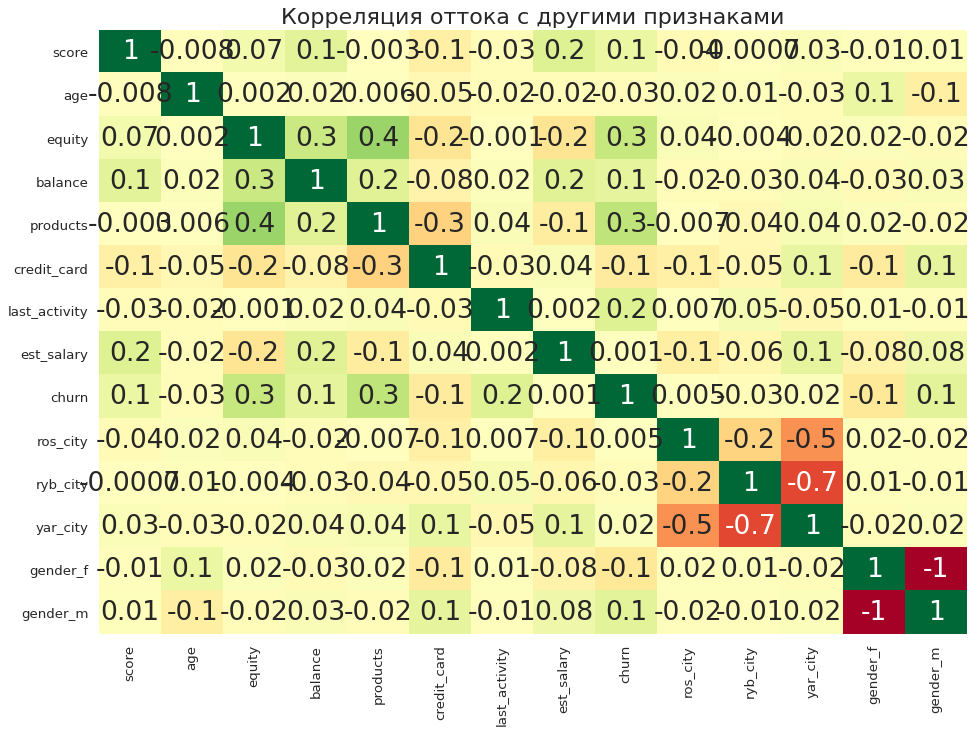

In [35]:
# построим матрицу корреляции всех признаков по методу Пирсона
plt.figure(figsize=(14,10), dpi=80)
sns.heatmap(df.corr(method='pearson'), xticklabels=df.corr().columns, yticklabels=df.corr(). \
            columns, cmap='RdYlGn', center=0, annot=True, fmt = '.1g', cbar=False)

# Decorations
plt.title('Корреляция оттока с другими признаками', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

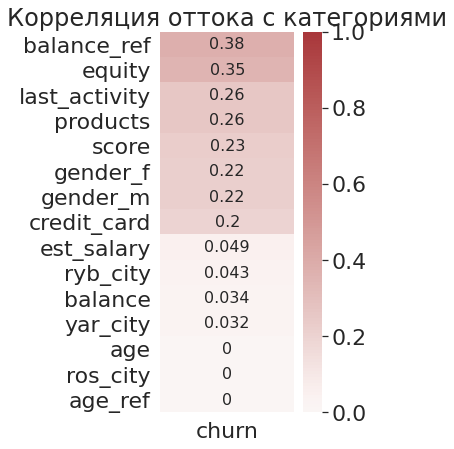

In [36]:
# построим матрицу по корреляции в столбце churn
plt.figure(figsize = (3,7))
churn_mat = df.phik_matrix(interval_cols=['score', 'age', 'est_salary', 'balance'])[['churn']] \
    .drop(index='churn', axis=0).sort_values(by='churn', ascending=False)
sns.heatmap(churn_mat, annot=True, fmt='.2g',  vmax=1, vmin=0, cmap='vlag', center = 0, annot_kws={"fontsize":16})
sns.set(font_scale=2)
plt.title('Корреляция оттока с категориями')
plt.show()

In [37]:
# построим отдельную матрицу корреляции, отсортируем по параметру оттока
cor_matrix = df[['score','equity','products','credit_card', 'last_activity', 'est_salary', 'churn']].corr()
cor_matrix.sort_values(by='churn', ascending=False, inplace=True)

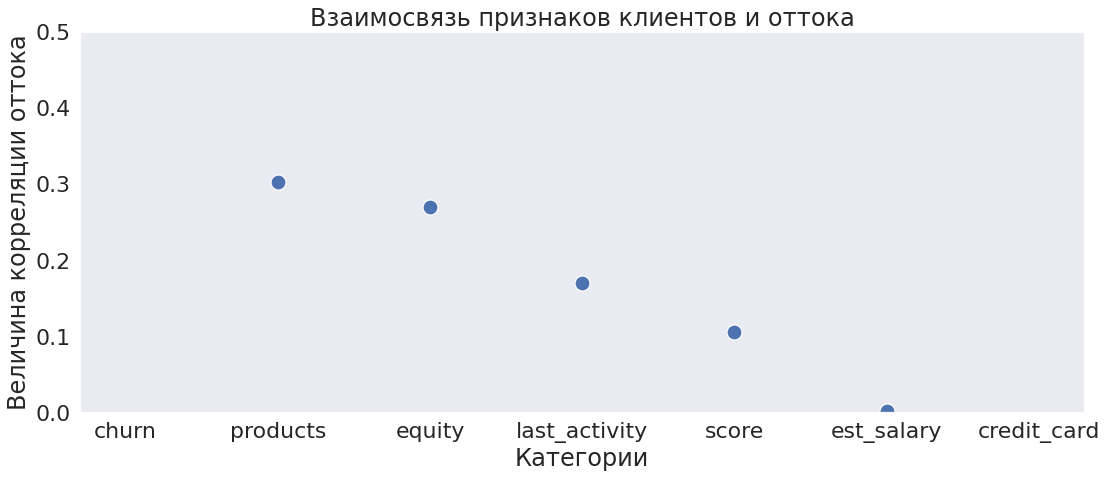

In [38]:
# построим график по отсортированной матрице
plt.rcParams['figure.figsize']=(18,7)
plt.rcParams['lines.markersize'] = 15
sns.scatterplot(data=cor_matrix['churn'])
plt.xlabel('Категории')
plt.ylabel('Величина корреляции оттока')
plt.ylim(0, 0.5)
plt.grid()
plt.title('Взаимосвязь признаков клиентов и оттока')
plt.show()

Согласно шкале Чеддока, сила связи:

- 0,1 - 0,3	 слабая
- 0,3 - 0,5	 умеренная
- 0,5 - 0,7	 заметная
- 0,7 - 0,9  высокая
- 0,9 - 0,99 весьма высокая

Исходя из графика можно предположить, что у параметров products, equity, last_activity, gender, score связь слабая, balance очень слабая, est_salary околонулевая, прочие имеют отсутствующее значение.

### Анализ признаков относительно признака оттока<a id="churn_analysis"></a>

#### score

In [39]:
# посчитаем процентное соотношение ушедших клиентов по признаку score* 
score_off = df.pivot_table(index = 'score', values = 'churn', aggfunc = ['sum', 'count'])
score_off.columns = score_off.columns.droplevel(level=1)
score_off['perc'] = (score_off['sum']/score_off['count']*100).round(1)
score_off = score_off[score_off['sum']==1]
score_off.head(5)

,sum,count,perc
score,,,
706,1,11,9.1
707,1,6,16.7
727,1,12,8.3
728,1,9,11.1
730,1,8,12.5


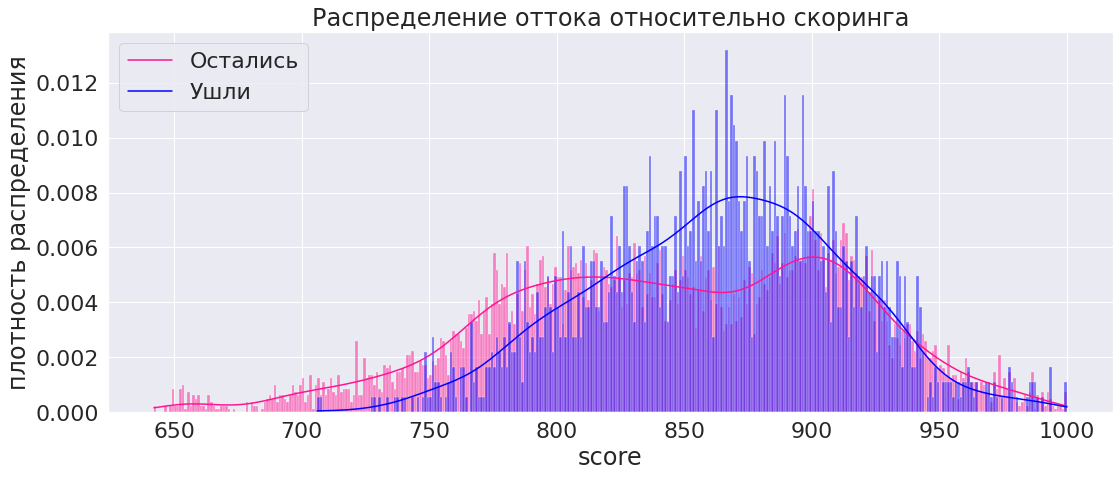

In [40]:
plt.rcParams['figure.figsize']=(18,7)
sns.histplot(df.query('churn == 0')['score'], kde=True, alpha=0.5, stat="density", common_norm=False, binwidth=1, \
            color='#FF1493')
sns.histplot(df.query('churn == 1')['score'], kde=True, alpha=0.5, stat="density", common_norm=False, binwidth=1, \
            color='#0000FF')
plt.legend(loc='upper left', labels=['Остались', 'Ушли'])
plt.title('Распределение оттока относительно скоринга')
plt.xlabel('score')
plt.ylabel('плотность распределения')
plt.show()

Исходя из графика можно предположить, что наибольшее количество уходящих клиентов обладают рейтингом в промежутке от 830 до 900 пунктов, с условным центром в районе 853. Что характерно, клиенты со счётом ниже 706 не уходят.

#### age

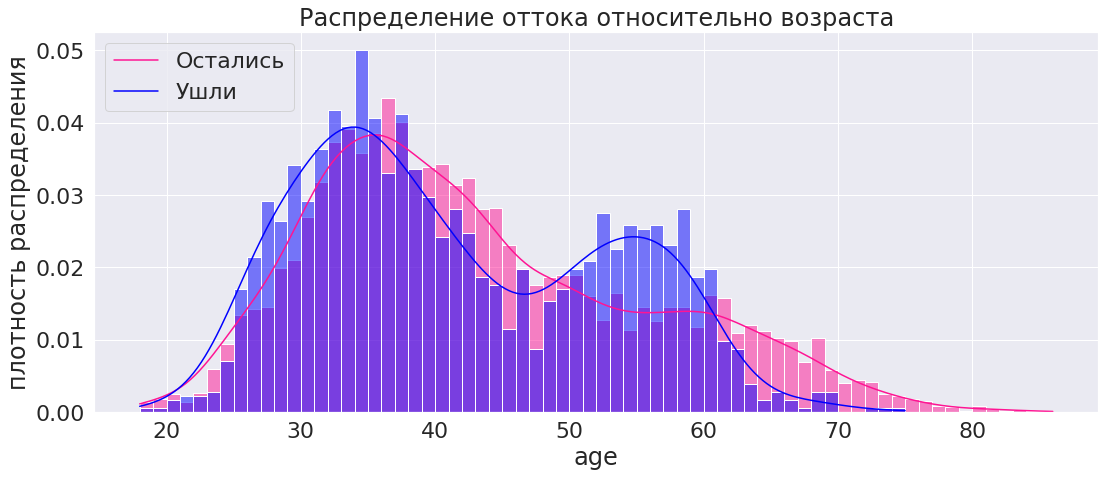

In [41]:
plt.rcParams['figure.figsize']=(18,7)
sns.histplot(df_true.query('churn == 0')['age'], kde=True, alpha=0.5, stat="density", common_norm=False, binwidth=1, \
            color='#FF1493')
sns.histplot(df_true.query('churn == 1')['age'], kde=True, alpha=0.5, stat="density", common_norm=False, binwidth=1, \
            color='#0000FF')
plt.legend(loc='upper left', labels=['Остались', 'Ушли'])
plt.title('Распределение оттока относительно возраста')
plt.xlabel('age')
plt.ylabel('плотность распределения')
plt.show()

Как видно из распределения, есть 2 области - от 26 до 39, и от 51 до 61, где уровень отточных клиентов превышает уровень оставшихся. 

#### gender

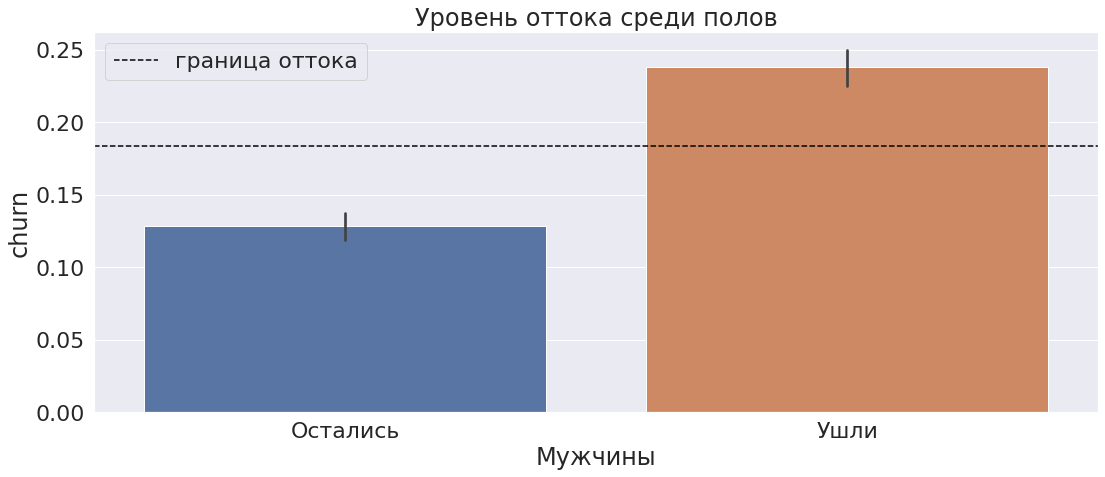

In [42]:
# построим дисперсию оттока среди мужчин
plt.rcParams['figure.figsize']=(18,7)
sns.set(font_scale=2.0)
gm=sns.barplot(x='gender_m', y='churn', data=df)
plt.axhline(df['churn'].mean(), color='black', ls='--', label="граница оттока")
plt.legend()
plt.xlabel('Мужчины')
plt.title('Уровень оттока среди полов')
gm.set(xticklabels=['Остались', 'Ушли'])
plt.show()

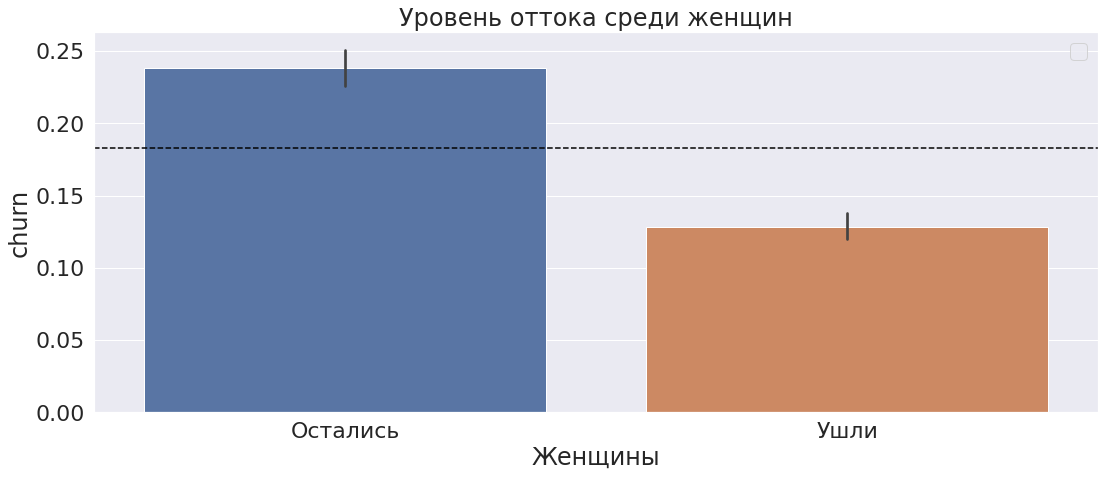

In [43]:
# построим дисперсию оттока среди женщин
plt.rcParams['figure.figsize']=(18,7)
sns.set(font_scale=2.0)
gf=sns.barplot(x='gender_f', y='churn', data=df)
plt.axhline(df['churn'].mean(), color='black', ls='--', label="граница оттока")
plt.legend('')
plt.xlabel('Женщины')
plt.title('Уровень оттока среди женщин')
gf.set(xticklabels=['Остались', 'Ушли'])
plt.show()

Исходя из графика можно предположить, что наибольшее количество уходящих клиентов во всех возрастных категориях - мужчины.

#### equity

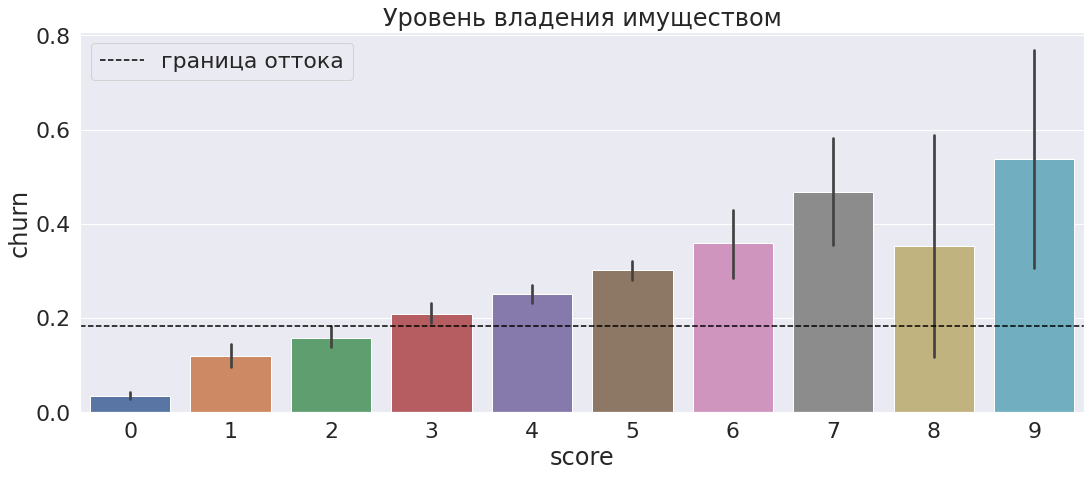

In [44]:
# построим дисперсию оттока по признаку equity
plt.rcParams['figure.figsize']=(18,7)
sns.set(font_scale=2.0)
sns.barplot(x='equity', y='churn', data=df)
plt.axhline(df['churn'].mean(), color='black', ls='--', label="граница оттока")
plt.legend()
plt.xlabel('score')
plt.title('Уровень владения имуществом')
plt.show()

Исходя из графика можно предположить, что наибольшее количество уходящих клиентов имеют значение equity 3 и выше.

#### balance

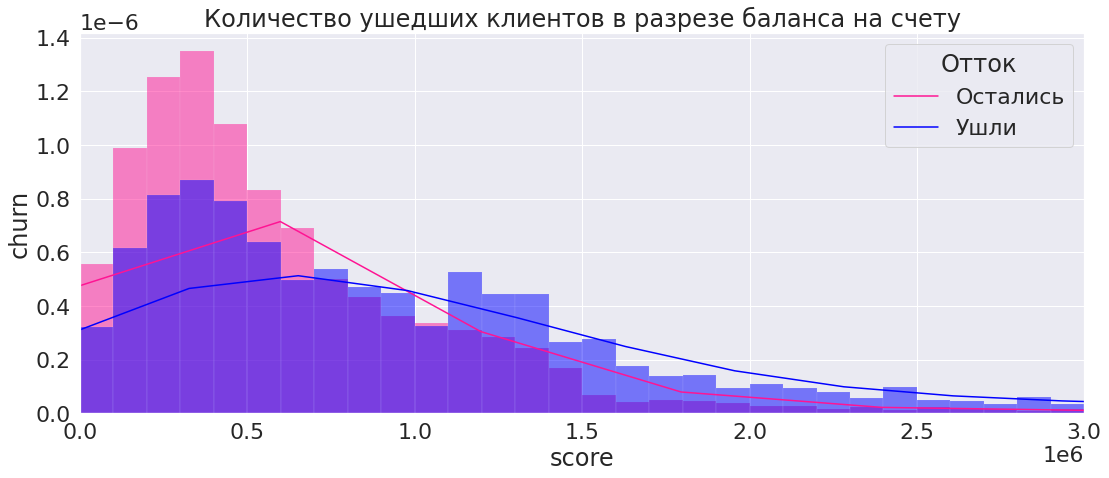

In [45]:
# построим гистрорамму оттока по признаку balance
df_balance = df_true.dropna()
plt.rcParams['figure.figsize']=(18,7)
sns.histplot(df_balance.query('churn == 0')['balance'], kde=True, alpha=0.5, stat="density", common_norm=False, binwidth=100000, \
            color='#FF1493')
sns.histplot(df_balance.query('churn == 1')['balance'], kde=True, alpha=0.5, stat="density", common_norm=False, binwidth=100000, \
            color='#0000FF')
plt.legend(title='Отток', loc='upper right', labels=['Остались', 'Ушли'])
plt.title('Количество ушедших клиентов в разрезе баланса на счету')
plt.xlim(0, 3000000)
plt.xlabel('score')
plt.ylabel('churn')
plt.show()

Исходя из графика можно предположить, что наибольшее количество уходящих клиентов держали на счету около 300.000 рублей, меньшая часть уходила по достижении 1.200.000 рублей.

#### products

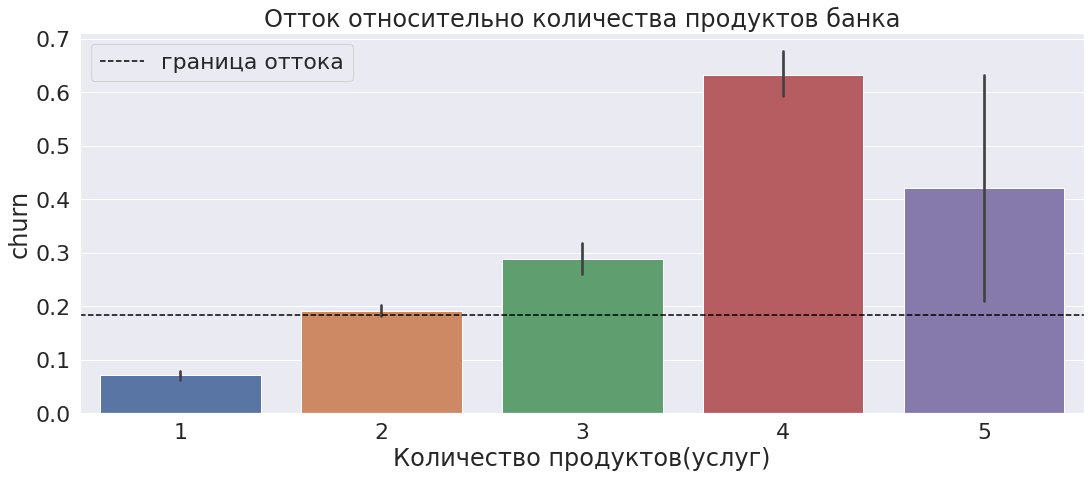

In [46]:
# построим дисперсию оттока по признаку products
plt.rcParams['figure.figsize']=(18,7)
sns.set(font_scale=2.0)
sns.barplot(x='products', y='churn', data=df)
plt.axhline(df['churn'].mean(), color='black', ls='--', label="граница оттока")
plt.legend()
plt.xlabel('Количество продуктов(услуг)')
plt.title('Отток относительно количества продуктов банка')
plt.show()

Исходя из графика можно предположить, что наибольшее количество уходящих клиентов пользуются 2-мя и более продуктами.

#### last_activity

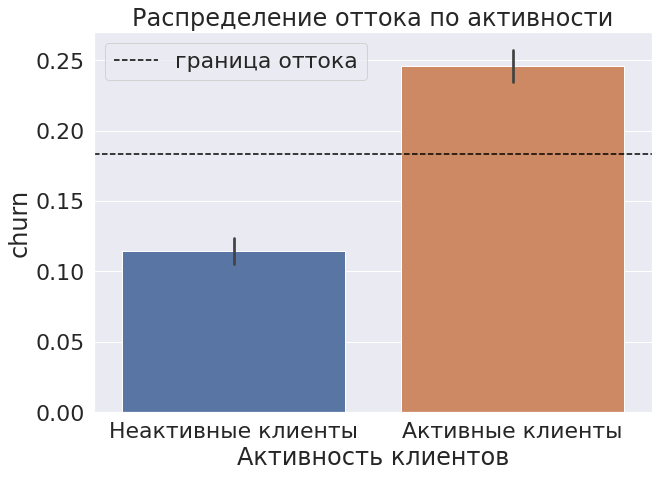

In [47]:
# построим гистрорамму оттока по признаку last_activity
plt.rcParams['figure.figsize']=(10,7)
sns.set(font_scale=2.0)
gla=sns.barplot(x='last_activity', y='churn', data=df)
plt.axhline(df['churn'].mean(), color='black', ls='--', label="граница оттока")
plt.legend()
plt.xlabel('Активность клиентов')
plt.title('Распределение оттока по активности')
gla.set(xticklabels=['Неактивные клиенты', 'Активные клиенты'])
plt.show()

Исходя из графика можно предположить, что наибольшее количество уходящих клиентов являются активными клиентыми.

#### est_salary

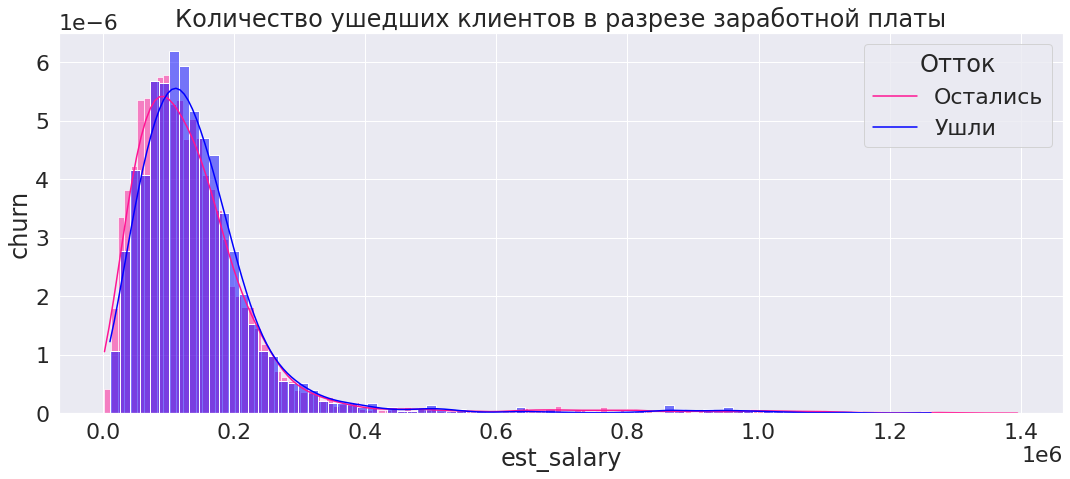

In [48]:
# построим гистрорамму оттока по признаку est_salary
plt.rcParams['figure.figsize']=(18,7)
sns.histplot(df.query('churn == 0')['est_salary'], kde=True, alpha=0.5, stat="density", common_norm=False,  \
            color='#FF1493')
sns.histplot(df.query('churn == 1')['est_salary'], kde=True, alpha=0.5, stat="density", common_norm=False,  \
            color='#0000FF')
plt.legend(title='Отток', loc='upper right', labels=['Остались', 'Ушли'])
plt.title('Количество ушедших клиентов в разрезе заработной платы')
plt.xlim()
plt.xlabel('est_salary')
plt.ylabel('churn')
plt.show()

#### credit_card

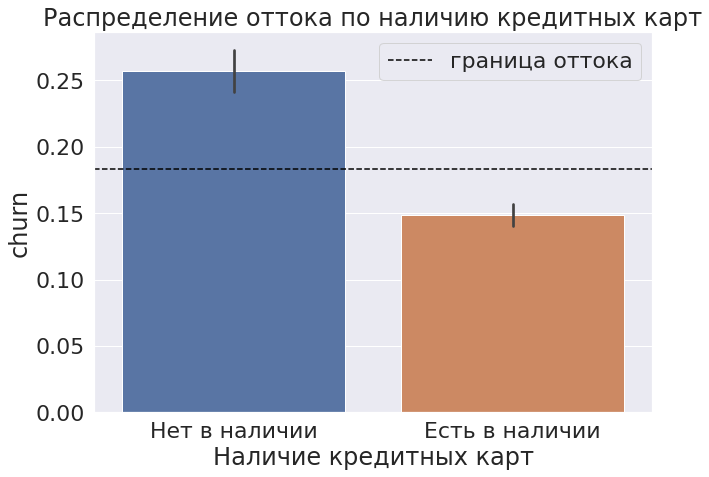

In [49]:
# построим гистрорамму оттока по признаку credit_card
plt.rcParams['figure.figsize']=(10,7)
sns.set(font_scale=2.0)
ax=sns.barplot(x='credit_card', y='churn', data=df)
plt.axhline(df['churn'].mean(), color='black', ls='--', label="граница оттока")
plt.legend()
plt.xlabel('Наличие кредитных карт')
plt.title('Распределение оттока по наличию кредитных карт')
ax.set(xticklabels=['Нет в наличии', 'Есть в наличии'])
plt.show()

Исходя из графика можно предположить, что наибольшее количество уходящих клиентов не пользуются кредитными картами.

#### city

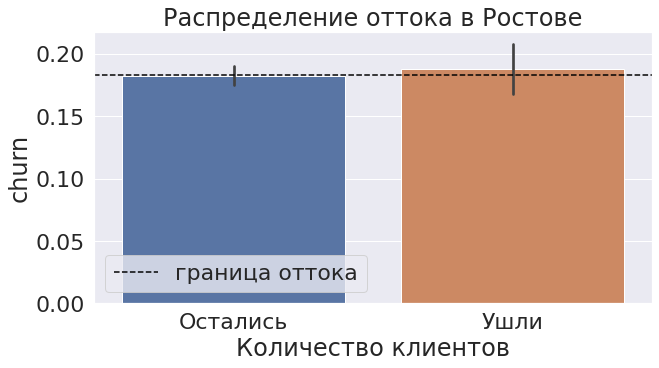

In [50]:
# построим гистрограмму оттока по городам отдельно
plt.rcParams['figure.figsize']=(10,5)
sns.set(font_scale=2.0)
ax=sns.barplot(x='ros_city', y='churn', data=df)
plt.axhline(df['churn'].mean(), color='black', ls='--', label="граница оттока")
plt.legend()
plt.xlabel('Количество клиентов')
plt.title('Распределение оттока в Ростове')
ax.set(xticklabels=['Остались', 'Ушли'])
plt.show()

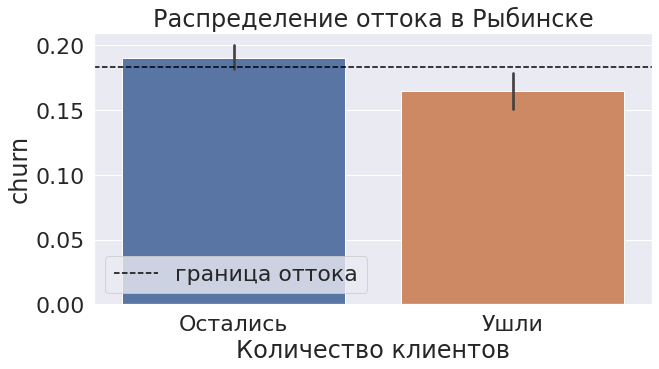

In [51]:
# построим гистрограмму оттока по городам отдельно
plt.rcParams['figure.figsize']=(10,5)
sns.set(font_scale=2.0)
ax=sns.barplot(x='ryb_city', y='churn', data=df)
plt.axhline(df['churn'].mean(), color='black', ls='--', label="граница оттока")
plt.legend()
plt.xlabel('Количество клиентов')
plt.title('Распределение оттока в Рыбинске')
ax.set(xticklabels=['Остались', 'Ушли'])
plt.show()

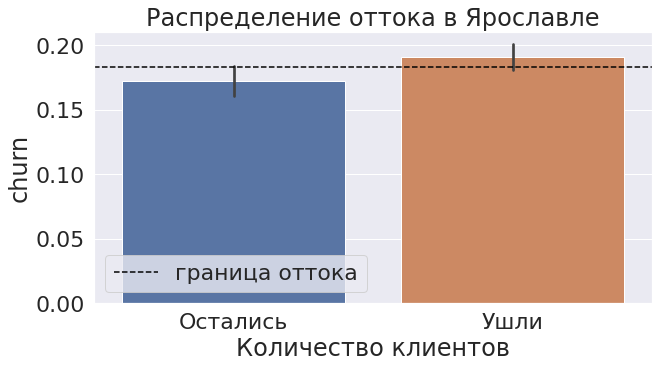

In [52]:
# построим гистрограмму оттока по городам отдельно
plt.rcParams['figure.figsize']=(10,5)
sns.set(font_scale=2.0)
ax=sns.barplot(x='yar_city', y='churn', data=df)
plt.axhline(df['churn'].mean(), color='black', ls='--', label="граница оттока")
plt.legend()
plt.xlabel('Количество клиентов')
plt.title('Распределение оттока в Ярославле')
ax.set(xticklabels=['Остались', 'Ушли'])
plt.show()

Исходя из графика можно предположить, что у уходящих клиентов нет предпочтения по городу обслуживания.

### Анализ портрета клиента в разрезе имеющихся признаков<a id="user_cut"></a>

Чтобы составить портрет клиента, необходимо определить существенные признаки. Таковыми для нас будут являться:
gender — пол;
age — возраст;
score — баллы кредитного скоринга;
equity — количество баллов собственности;
products - количество продуктов;
last_activity - показатель активности.

Иные признаки менее значимы и тоже могут оказывать влияние на отток, но это будет или более слабая связь, или связи уже вторых-третьих порядков.

In [53]:
# посчитаем моду по полу среди отточных пользователей, М - мужчины, Ж - женщины
df_true.query('churn==1')['gender'].mode(dropna=True)

0    М
dtype: object

In [54]:
# число пользователей в сегменте среди мужчин:
print ('Общее число пользователей среди мужчин:', df_true.query(
    'gender=="М" ')['userid'].count())
#число отточных пользователей в сегменте:
print ('Число отточных пользователей среди мужчин:', df_true.query(
    'gender=="М" and churn==1')['userid'].count())
#число лояльных пользователей в сегменте:
print ('Число лояльных пользователей среди мужчин:', df_true.query(
    'gender=="М" and churn==0')['userid'].count())
#соотношение отточных пользователей:
print ('Процент отточных пользователей среди мужчин:', 
      df_true.query ('gender=="М" and churn==1')['userid'].count() 
    / df_true.query ('gender=="М" and churn==0')['userid'].count()*100)

Общее число пользователей среди мужчин: 4972
Число отточных пользователей среди мужчин: 1183
Число лояльных пользователей среди мужчин: 3789
Процент отточных пользователей среди мужчин: 31.2219583003431


In [55]:
# число пользователей в сегменте среди женщин:
print ('Общее число пользователей среди женщин:', df_true.query(
    'gender=="Ж" ')['userid'].count())
#число отточных пользователей в сегменте:
print ('Число отточных пользователей среди женщин:', df_true.query(
    'gender=="Ж" and churn==1')['userid'].count())
#число лояльных пользователей в сегменте:
print ('Число лояльных пользователей среди женщин:', df_true.query(
    'gender=="Ж" and churn==0')['userid'].count())
#соотношение отточных пользователей:
print ('Процент отточных пользователей среди женщин:', 
      df_true.query ('gender=="Ж" and churn==1')['userid'].count() 
    / df_true.query ('gender=="Ж" and churn==0')['userid'].count()*100)

Общее число пользователей среди женщин: 4954
Число отточных пользователей среди женщин: 636
Число лояльных пользователей среди женщин: 4318
Процент отточных пользователей среди женщин: 14.729041222788327


In [56]:
# посчитаем моду по возрасту среди отточных пользователей
df_true.query('churn==1')['age'].mean().round()

41.0

In [57]:
#общее число пользователей в сегменте:
print ('Общее число пользователей:', df_true.query(
    'age==41')['userid'].count())
#число отточных пользователей в сегменте:
print ('Число отточных пользователей:', df_true.query(
    'age==41 and churn==1')['userid'].count())
#число лояльных пользователей в сегменте:
print ('Число лояльных пользователей:', df_true.query(
    'age==41 and churn==0')['userid'].count())
#соотношение отточных пользователей:
print ('Процент отточных пользователей:', 
      df_true.query ('age==41 and churn==1')['userid'].count() 
    / df_true.query ('age==41 and churn==0')['userid'].count()*100)

Общее число пользователей: 305
Число отточных пользователей: 51
Число лояльных пользователей: 254
Процент отточных пользователей: 20.078740157480315


In [58]:
# посчитаем моду по скоринговому счёту среди отточных пользователей
df_true.query('churn==1')['score'].mean().round()

863.0

In [59]:
#общее число пользователей в сегменте:
print ('Общее число пользователей:', df_true.query(
    'score==863')['userid'].count())
#число отточных пользователей в сегменте:
print ('Число отточных пользователей:', df_true.query(
    'score==863 and churn==1')['userid'].count())
#число лояльных пользователей в сегменте:
print ('Число лояльных пользователей:', df_true.query(
    'score==863 and churn==0')['userid'].count())
#соотношение отточных пользователей:
print ('Процент отточных пользователей:', 
      df_true.query ('score==863 and churn==1')['userid'].count() 
    / df_true.query ('score==863 and churn==0')['userid'].count()*100)

Общее число пользователей: 60
Число отточных пользователей: 11
Число лояльных пользователей: 49
Процент отточных пользователей: 22.448979591836736


In [60]:
# посчитаем моду по имущественному счёту среди отточных пользователей
df_true.query('churn==1')['equity'].mean().round()

4.0

In [61]:
#общее число пользователей в сегменте:
print ('Общее число пользователей:', df_true.query(
    'equity==4')['userid'].count())
#число отточных пользователей в сегменте:
print ('Число отточных пользователей:', df_true.query(
    'equity==4 and churn==1')['userid'].count())
#число лояльных пользователей в сегменте:
print ('Число лояльных пользователей:', df_true.query(
    'equity==4 and churn==0')['userid'].count())
#соотношение отточных пользователей:
print ('Процент отточных пользователей:', 
      df_true.query ('equity==4 and churn==1')['userid'].count() 
    / df_true.query ('equity==4 and churn==0')['userid'].count()*100)

Общее число пользователей: 1841
Число отточных пользователей: 464
Число лояльных пользователей: 1377
Процент отточных пользователей: 33.69644153957879


In [62]:
# посчитаем моду по количеству продуктов среди отточных пользователей
df_true.query('churn==1')['products'].mean().round()

2.0

In [63]:
#общее число пользователей в сегменте:
print ('Общее число пользователей:', df_true.query(
    'products==2')['userid'].count())
#число отточных пользователей в сегменте:
print ('Число отточных пользователей:', df_true.query(
    'products==2 and churn==1')['userid'].count())
#число лояльных пользователей в сегменте:
print ('Число лояльных пользователей:', df_true.query(
    'products==2 and churn==0')['userid'].count())
#соотношение отточных пользователей:
print ('Процент отточных пользователей:', 
      df_true.query ('products==2 and churn==1')['userid'].count() 
    / df_true.query ('products==2 and churn==0')['userid'].count()*100)

Общее число пользователей: 5099
Число отточных пользователей: 979
Число лояльных пользователей: 4120
Процент отточных пользователей: 23.762135922330096


In [64]:
# посчитаем моду по активности среди отточных пользователей
df_true.query('churn==1')['last_activity'].mean().round()

1.0

In [65]:
#общее число пользователей в сегменте:
print ('Общее число пользователей:', df_true.query(
    'last_activity==1')['userid'].count())
#число отточных пользователей в сегменте:
print ('Число отточных пользователей:', df_true.query(
    'last_activity==1 and churn==1')['userid'].count())
#число лояльных пользователей в сегменте:
print ('Число лояльных пользователей:', df_true.query(
    'last_activity==1 and churn==0')['userid'].count())
#соотношение отточных пользователей:
print ('Процент отточных пользователей:', 
      df_true.query ('last_activity==1 and churn==1')['userid'].count() 
    / df_true.query ('last_activity==1 and churn==0')['userid'].count()*100)

Общее число пользователей: 5197
Число отточных пользователей: 1278
Число лояльных пользователей: 3919
Процент отточных пользователей: 32.61035978565961


In [66]:
# посчитаем моду по заработку среди отточных пользователей
df_true.query('churn==1')['est_salary'].mode().round()

0     84957
1     88998
2    100072
3    112635
4    168163
dtype: int64

Как видно из вывода программы, считать моду по средней зарплате бессмысленно, т.к. выводится отдельное число для каждого пользователя.

In [67]:
# посчитаем моду по кредитным картам среди отточных пользователей
df_true.query('churn==1')['credit_card'].mode().round()

0    1
dtype: int64

In [68]:
#общее число пользователей в сегменте:
print ('Общее число пользователей:', df_true.query(
    'credit_card==1')['userid'].count())
#число отточных пользователей в сегменте:
print ('Число отточных пользователей:', df_true.query(
    'credit_card==1 and churn==1')['userid'].count())
#число лояльных пользователей в сегменте:
print ('Число лояльных пользователей:', df_true.query(
    'credit_card==1 and churn==0')['userid'].count())
#соотношение отточных пользователей:
print ('Процент отточных пользователей:', 
      df_true.query ('credit_card==1 and churn==1')['userid'].count() 
    / df_true.query ('credit_card==1 and churn==0')['userid'].count()*100)

Общее число пользователей: 6749
Число отточных пользователей: 1003
Число лояльных пользователей: 5746
Процент отточных пользователей: 17.45562130177515


In [69]:
# посчитаем моду по месту обслуживания среди отточных пользователей
# впрямую это сделать нельзя, поэтому просто посчитаем количество отточных пользователй в городах
print ('Число отточных пользователей Ростова:',df_true.query('city=="Ростов" and churn==1')['userid'].count())
print ('Число отточных пользователей Рыбинска:',df_true.query('city=="Рыбинск" and churn==1')['userid'].count())
print ('Число отточных пользователей Ярославля:',df_true.query('city=="Ярославль" and churn==1')['userid'].count())

Число отточных пользователей Ростова: 266
Число отточных пользователей Рыбинска: 436
Число отточных пользователей Ярославля: 1117


Итого, больше всего отточных пользователей обслуживается в Ярославле.

In [70]:
#общее число пользователей в сегменте:
print ('Общее число пользователей:', df_true.query(
    'city=="Ярославль"')['userid'].count())
#число отточных пользователей в сегменте:
print ('Число отточных пользователей:', df_true.query(
    'city=="Ярославль" and churn==1')['userid'].count())
#число лояльных пользователей в сегменте:
print ('Число лояльных пользователей:', df_true.query(
    'city=="Ярославль" and churn==0')['userid'].count())
#соотношение отточных пользователей:
print ('Процент отточных пользователей:', 
      df_true.query ('city=="Ярославль" and churn==1')['userid'].count() 
    / df_true.query ('city=="Ярославль" and churn==0')['userid'].count()*100)

Общее число пользователей: 5856
Число отточных пользователей: 1117
Число лояльных пользователей: 4739
Процент отточных пользователей: 23.57037349651825


In [71]:
# построим таблицу признаков
temp=(df_true.query('churn==0')[['score', 'age', 'balance', 'est_salary', 'equity']].mean().round(1).reset_index()).merge(
 (df_true.query('churn==1')[['score','age','balance','est_salary','equity']].mean().round(1).reset_index()),on='index')    

In [72]:
#делаем таблицы мод для отточных и лояльных людей
moda_on = df_true.query('churn==0')[['gender', 'credit_card', 'last_activity', 'city', 'products']].mode().T.reset_index()
moda_of = df_true.query('churn==1')[['gender', 'credit_card', 'last_activity', 'city', 'products']].mode().T.reset_index()

In [73]:
#объединяем в одну таблицу
table = pd.concat([temp,moda_on,moda_of])

In [74]:
table=table.rename(columns={'index': 'Категория', '0_x': 'Лояльные', '0_y': 'Отточные', 0: 'Значение моды'})
table['Разница в %'] = ((1-table['Отточные']/table['Лояльные'])*100).round(1)

In [75]:
table.fillna('-', inplace=True)

In [76]:
display(table)

,Категория,Лояльные,Отточные,Значение моды,Разница в %
0,score,845.4,863.3,-,-2.1
1,age,43.0,41.4,-,3.7
2,balance,734823.0,1133993.3,-,-54.3
3,est_salary,147812.0,148310.2,-,-0.3
4,equity,2.4,3.8,-,-58.3
0,gender,-,-,Ж,-
1,credit_card,-,-,1,-
2,last_activity,-,-,0,-
3,city,-,-,Ярославль,-
4,products,-,-,2,-


Исходя из всех полученных данных можно предположить, что для отточного клиента банка характерно следующее:

- Мужской пол;
- Возраст - 41 год;
- Средний балл скоринга — 863;
- Имущественный балл — 4;
- Баланс на счету - 1.13 млн. руб.;
- Количество банковских продуктов — 2;
- Кредитная карта — не используется;
- Активность — активный пользователь услуг банка;
- Зарплата — около 148 тыс.;
- Предпочитаемый город обслуживания — Ярославль.

Исходя из всех полученных данных можно предположить, что для лояльного клиента банка характерно следующее:

- Женский пол;
- Возраст - 43 года;
- Средний балл скоринга — 854;
- Имущественный балл — 2;
- Баланс на счету - 734 тыс. руб.;
- Количество банковских продуктов — 2;
- Кредитная карта — используется;
- Активность — не является активным пользователем;
- Зарплата — около 147 тыс.;
- Предпочитаемый город обслуживания — Ярославль.

## Выдвижение гипотез<a id="hypos"></a>

### Формирование списка гипотез<a id="hypo_list"></a>

В данном разделе мы выдвинем и проверим ряд гипотез:

- Гипотеза №1: проверка разницы заработной платы оставшихся и ушедших клиентов, чтобы ответить на вопрос, есть ли разница в зарплате между лояльными и уходящими клиентами?

- Гипотеза №2: проверка разницы кредитного рейтинга оставшихся и ушедших клиентов, чтобы ответить на вопрос, есть ли разница в скоринге между лояльными и уходящими клиентами?

### Проверка гипотез<a id="hypo_test"></a>

In [77]:
# Разделим фрейм на две части по оттоку
df_0 = df.query('churn == 0')
df_1 = df.query('churn == 1')

#### Гипотеза №1: проверка разницы заработной платы оставшихся и ушедших клиентов

Сформулируем нулевую и альтернативную гипотезы:

- H0: средние доходы оставшихся и ушедших клиентов равны
- H1: средние доходы оставшихся и ушедших клиентов не равны

In [78]:
#посмотрим дисперсию выборки
print('Дисперсия первой выборки = ', round(np.var(df_0['est_salary']),2))
print('Дисперсия второй выборки = ', round(np.var(df_1['est_salary']),2))

Дисперсия первой выборки =  20390948657.7
Дисперсия второй выборки =  15099626926.62


In [79]:
#посмотрим размеры выборки
print('Размер первой выборки = ', len(df_0['est_salary']))
print('Размер второй выборки = ', len(df_1['est_salary']))

Размер первой выборки =  8107
Размер второй выборки =  1819


Так как данные на графике в целом распределены нормально (близко к гауссиане), но правая часть графика указывает на возможное наличие выбросов, то будем использовать U-критерий Манна — Уитни, которорый является непараметрическим аналогом критерия Стьюдента.

In [80]:
# уровень статистической значимости стандартный
alpha = 0.05

results = st.mannwhitneyu(df_0['est_salary'], df_1['est_salary'])

print(results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.00022708135010035758
Отвергаем нулевую гипотезу


#### Гипотеза №2: проверка разницы кредитного скоринга оставшихся и ушедших клиентов

Сформулируем нулевую и альтернативную гипотезы:

- H0: среднее значение кредитного скоринга оставшихся и ушедших клиентов равно
- H1: среднее значение кредитного скоринга оставшихся и ушедших клиентов не равно

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


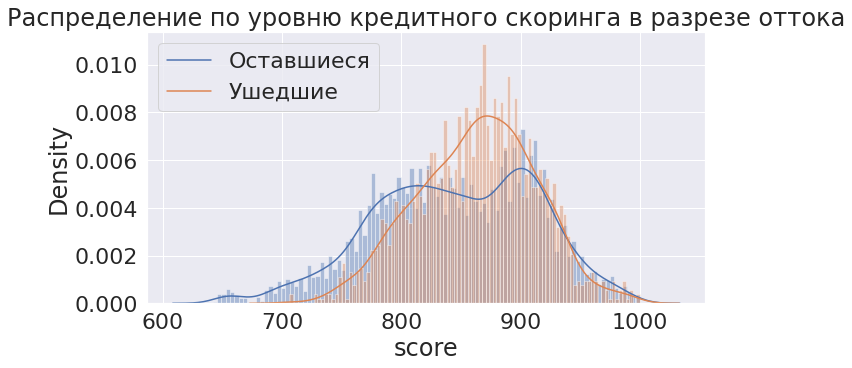

In [81]:
sns.distplot(df_0['score'], bins=100)
sns.distplot(df_1['score'], bins=100)
plt.title('Распределение по уровню кредитного скоринга в разрезе оттока')
plt.legend(['Оставшиеся', 'Ушедшие'])
plt.show();

In [82]:
#посмотрим дисперсию выборки
print('Дисперсия первой выборки = ', round(np.var(df_0['score']),2))
print('Дисперсия второй выборки = ', round(np.var(df_1['score']),2))

Дисперсия первой выборки =  4624.33
Дисперсия второй выборки =  2455.95


In [83]:
#посмотрим размеры выборки
print('Размер первой выборки = ', len(df_0['score']))
print('Размер второй выборки = ', len(df_1['score']))

Размер первой выборки =  8107
Размер второй выборки =  1819


Так как левая часть графика длиннее из-за влияния лояльных клиентов, обладающих более низкими рейтингами, а график уходящих клиентов имеет выбросы в районе 860-870 баллов, то мы будем использовать U-критерий Манна — Уитни, которорый является непараметрическим аналогом критерия Стьюдента и является более устройчивым к влиянию выбросов.

In [84]:
# уровень статистической значимости стандартный
alpha = 0.05

res = st.mannwhitneyu(df_0['score'], df_1['score'])

print ('p-значение:', res.pvalue) 

if res.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

p-значение: 6.664136275637176e-22
Отвергаем нулевую гипотезу


## Промежуточные выводы<a id="pref_total"></a>

### Выводы по анализу клиентских признаков и их корреляции<a id="corr_total"></a>

Исходя из составленного клиентского портрета, самыми выделяющимися в порядке убывания являются параметры equity, last_activity, balance и products, т.е. чаще всего уходят клиенты с большим количеством недвижимости, активно использующие банковскую экосистему, с высоким балансом на счету, и с большим количеством банковских продуктов,  мужчины при этом уходят чаще женщин.

### Выводы по проверенным гипотезам<a id="hypo_total"></a>

Между ушедшими и оставшимися есть заметная разницы по уровню заработной платы, и более высокооплачиваемые клиенты уходят чаще.

Между ушедшими и оставшимися есть заметная разница по уровню кредитного рейтинга, и люди с более высоким рейтингом уходят чаще, а не достигшие рейтинга 706 баллов не покидают банк вообще.

## Сегментация<a id="slicing"></a>

### Сегментация клиентской базы по заданным параметрам<a id="client_slicing"></a>

Исходя из ранее проведённых исследований нужно выделить несколько клиентских сегментов с наиболее высоким уровнем оттока.
Наиболее важными критериями для нас будут - пол, возраст, скоринговый рейтинг, недвижимость и количество продуктов.
Исследуем сегменты и найдём сегменты с самым высоким уровнем оттока. 

Сегмент 1

Пол: мужчины
Возраст: от 26 до 39 лет
Скоринг: от 830 до 900

In [85]:
#общее число пользователей в сегменте:
print('Общее число пользователей в сегменте №1:', df_true.query(
    'gender=="М" and score>=830 and score<= 900  \
    and age>=26 and age<=39')['userid'].count())

#число отточных пользователей в сегменте:
print('Число отточных пользователей в сегменте №1:', df_true.query(
    'gender=="М" and score>=830 and score<= 900  \
    and age>=26 and age<=39 and churn==1')['userid'].count())

#соотношение отточных пользователей:
print('Процент отточных пользователей в сегменте №1:', 
      df_true.query('gender=="М" and score>=830 and score<= 900  \
    and age>=26 and age<=39 and churn==1')['userid'].count() 
    / df_true.query('gender=="М" and score>=830 and score<= 900  \
    and age>=26 and age<=39')['userid'].count()*100)

Общее число пользователей в сегменте №1: 912
Число отточных пользователей в сегменте №1: 304
Процент отточных пользователей в сегменте №1: 33.33333333333333


Сегмент 2

Возраст: от 56 до 61 лет
Недвижимость: 3+

In [86]:
#общее число пользователей в сегменте:
print('Общее число пользователей в сегменте №2:', df_true.query(
    '  age>=56 and age<=61 and equity>=3')['userid'].count())

#число отточных пользователей в сегменте:
print('Число отточных пользователей в сегменте №2:', df_true.query(
    'age>=56 and age<=61 and equity>=3 and churn==1')['userid'].count())

#соотношение отточных пользователей:
print('Процент отточных пользователей в сегменте №2:', 
      df_true.query('age>=56 and age<=61 and equity>=3 and churn==1')['userid'].count() 
    / df_true.query('age>=56 and age<=61 and equity>=3')['userid'].count()*100)

Общее число пользователей в сегменте №2: 537
Число отточных пользователей в сегменте №2: 171
Процент отточных пользователей в сегменте №2: 31.843575418994412


Сегмент 3

Продукты: 2+
Активность: да
Кредитные карты: да

In [87]:
#общее число пользователей в сегменте:
print('Общее число пользователей в сегменте №3:', df_true.query(
    'credit_card==1 and last_activity==1 and products>=2')['userid'].count())

#число отточных пользователей в сегменте:
print('Число отточных пользователей в сегменте №3:', df_true.query(
    'credit_card==1 and last_activity==1 and products>=2 and churn==1')['userid'].count())

#соотношение отточных пользователей:
print('Процент отточных пользователей в сегменте №3:', 
      df_true.query('credit_card==1 and last_activity==1 and products>=2 and churn==1')['userid'].count() 
    / df_true.query('credit_card==1 and last_activity==1 and products>=2')['userid'].count()*100)

Общее число пользователей в сегменте №3: 1965
Число отточных пользователей в сегменте №3: 522
Процент отточных пользователей в сегменте №3: 26.564885496183205


Сегмент 4

Пол: мужчины
Зарплата: от 147900 до 220000 руб
Баланс на счёте: до 1.13 млн. руб.

In [88]:
#общее число пользователей в сегменте:
print('Общее число пользователей в сегменте №4:', df_true.query(
    'gender=="М" and balance<=1130000  \
    and est_salary>=147900 and est_salary<=220000')['userid'].count())

#число отточных пользователей в сегменте:
print('Число отточных пользователей в сегменте №4:', df_true.query(
    'gender=="М" and balance<=1130000  \
    and est_salary>=147900 and est_salary<=220000 and churn==1')['userid'].count())

#соотношение отточных пользователей:
print('Процент отточных пользователей в сегменте №4:', 
      df_true.query('gender=="М" and balance<=1130000  \
    and est_salary>=147900 and est_salary<=220000 and churn==1')['userid'].count() 
    / df_true.query('gender=="М" and balance<=1130000  \
    and est_salary>=147900 and est_salary<=220000')['userid'].count()*100)

Общее число пользователей в сегменте №4: 562
Число отточных пользователей в сегменте №4: 147
Процент отточных пользователей в сегменте №4: 26.156583629893237


###  Выявление сегментов, в которых доля оттока наиболее высока, приоритезация сегментов<a id="slice_prior"></a>

Ранжирование сегментов в порядке убывания веса уходящих клиентов:

- Доля отточных пользователей в сегменте №1: 33.33%
- Доля отточных пользователей в сегменте №2: 31.84%
- Доля отточных пользователей в сегменте №3: 26.56%
- Доля отточных пользователей в сегменте №4: 26.15%

## Общие выводы о потенциальной возможности удержания клиентов<a id="itogo"></a>

### Описание получившихся клиентских групп, чьи члены чаще всего выбирают выход из обслуживания<a id="slacker_group"></a>

Исходя из ранее проведённых исследований, можно прийти к выводу, что среди клиентов чаще всего уходят мужчины, в возрасте от 26 до 47 лет, с кредитным скорингом от 830 до 900 баллов, имеющие собственное жильё - 3 балла и более, а возможно, и не одно, активно пользующиеся 2 и более услугами банка - но не кредитными продуктами, хранящие на счетах чуть более миллиона рублей в кубышке при доходе около 150 тысяч рублей, и без явного предпочтения города пребывания.

### Предложения по возвращению и удержанию групп оттока<a id="bind_group"></a>

Для сегмента 1 рекомендуется пересмотреть условия получения баллов в системе банка. Возможно, человек с низким скорингом, но являющийся клиентом банка долгое время и аккуратно платящий по счетам заслуживает небольшого поощрения?

Для сегмента 2 рекомендуется пересмотреть условия по ипотечным кредитам, ставки по страхованию жилья, возможно, пересмотреть сами процедуры, сделать их более удобными, а часть из них вообще перенести в онлайн, без необходимости посещать офис. Также, так как эти клиенты находятся в предпенсионном возрасте, можно предлагать им сельскую ипотеку или программы переселения в другие районы страны.

Для сегмента 3 рекомендуется пересмотреть программу лояльности, кэшбек и \или систему баллов, а также пересмотреть тарифы на обслуживание. Возможно, стоит ввести что-то вроде фиксированной абонентской платы за определённый набор продуктов, а не постоянную комиссию.

Для сегмента 4 рекомендуется пересмотреть условия зарплатных проектов и программу накоплений - процентные ставки, сроки и условия вкладов, возможно, более разнообразные предложения - брокерские счета, ПИФ-ы, программы с участием государства, металлические счета и т.д.